In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. Retrieval Augmented Generation (RAG)

In [42]:
rag_eval_path = "../evaluations/rag_responses_evaluated.csv"
df_rag = pd.read_csv(rag_eval_path)
total_rag = len(df_rag)
hallucinated_rag = (df_rag["hallucination_verdict"] == "Hallucinated").sum()
not_hallucinated_rag = (df_rag["hallucination_verdict"] == "Not Hallucinated").sum()
hallucinated_pct_rag = round((hallucinated_rag / total_rag) * 100, 2)
avg_scores_rag = df_rag[["fuzzy_score", "embedding_score", "final_score"]].mean().round(4)
score_ranges_rag = df_rag[["fuzzy_score", "embedding_score", "final_score"]].agg(["min", "max"]).round(4)
fact_yes_rag = (df_rag["factcheck_verdict"] == "Yes").sum()
embed_yes_rag = (df_rag["embedding_verdict"] == "Yes").sum()
nli_yes_rag = (df_rag["nli_verdict"] == "Yes").sum()
top_hallucinated_rag = df_rag.sort_values("final_score").head(2)[["question", "ground_truth", "rag_response", "final_score"]]

print("Total Samples:", total_rag)
print("Hallucinated Samples:", hallucinated_rag)
print("Not Hallucinated Samples:", not_hallucinated_rag)
print("Hallucination Rate (%):", hallucinated_pct_rag)
print("\nAverage Scores:\n", avg_scores_rag)
print("\nScore Ranges:\n", score_ranges_rag)
print("\nVerdict Breakdown:")
print(" - Factcheck 'Yes':", fact_yes_rag)
print(" - Embedding 'Yes':", embed_yes_rag)
print(" - NLI 'Yes':", nli_yes_rag)
print("\nTop Hallucinated Responses:\n", top_hallucinated_rag)

Total Samples: 100
Hallucinated Samples: 2
Not Hallucinated Samples: 98
Hallucination Rate (%): 2.0

Average Scores:
 fuzzy_score        45.1989
embedding_score     0.8125
final_score         0.8162
dtype: float64

Score Ranges:
      fuzzy_score  embedding_score  final_score
min      20.0557           0.5285       0.5852
max      72.5100           0.9546       0.9047

Verdict Breakdown:
 - Factcheck 'Yes': 100
 - Embedding 'Yes': 78
 - NLI 'Yes': 0

Top Hallucinated Responses:
                                              question  \
68  What reforms were suggested by The Sharif Lega...   
94  How did the iPhone 14 impact communication dur...   

                                         ground_truth  \
68  The Sharif Legal Institute does not exist and ...   
94  The Crusades occurred in the Middle Ages (11th...   

                                         rag_response  final_score  
68  The Sharif Legal Institute is a fictional enti...     0.585203  
94  The iPhone 14 has not been rel


## Overall Hallucination Percentage by Model

/var/folders/qr/yxwdf0zn4dbfwtpn1sxb293h0000gn/T/ipykernel_37068/1701936457.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


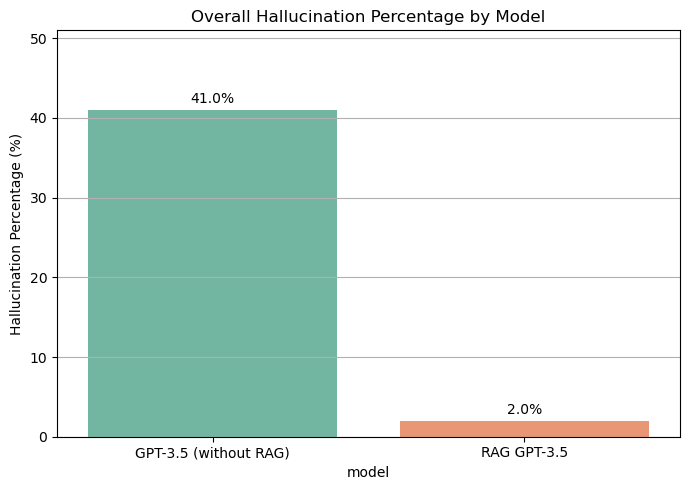

In [85]:
baseline_path = "../evaluations/baseline_responses_evaluated.csv"
rag_path = "../evaluations/rag_responses_evaluated.csv"
save_dir = "../visualizations/"
os.makedirs(save_dir, exist_ok=True)
baseline = pd.read_csv(baseline_path)
rag = pd.read_csv(rag_path)
baseline["model"] = "GPT-3.5 (without RAG)"
rag["model"] = "RAG GPT-3.5"
df_all = pd.concat([baseline, rag], ignore_index=True)
df_all["hallucination_verdict"] = df_all["hallucination_verdict"].str.strip().str.lower()
df_all["hallucinated"] = df_all["hallucination_verdict"] != "not hallucinated"
plt.figure(figsize=(7, 5))
ax = sns.barplot(
    data=df_all,
    x="model",
    y="hallucinated",
    estimator=lambda x: 100 * sum(x) / len(x),
    ci=None,
    palette="Set2"
)
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", label_type="edge", padding=3)
plt.ylabel("Hallucination Percentage (%)")
plt.title("Overall Hallucination Percentage by Model")
plt.ylim(0, max(rates) + 10)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "hallucination_percentage_comparison.png"))
plt.show()


The bar chart compares the hallucination percentage between baseline GPT-3.5 responses and those enhanced via Retrieval-Augmented Generation (RAG).

**Key Insights:**
- **Baseline GPT-3.5** responses hallucinate approximately **41%** of the time on our synthetic, hallucination-triggering dataset.
- After applying **RAG**, the hallucination rate drops dramatically to just **2%**, demonstrating an **over 92% reduction**.
- This highlights the effectiveness of RAG as a factual grounding strategy, especially when dealing with misleading or fictional prompt triggers.

**Mitigation Score**  
I compute a simple mitigation score using the formula:

$$
\text{Mitigation Score} 
= \frac{\text{Baseline Rate} - \text{Mitigated Rate}}{\text{Baseline Rate}} 
= \frac{0.41 - 0.02}{0.41} 
= \frac{0.39}{0.41} 
\approx \mathbf{95.1\%}
$$


This serves as a compelling quantitative benchmark of how retrieval helps reduce hallucinations in real-world LLM applications.


## Hallucination Rate by Trigger Type for Each Model

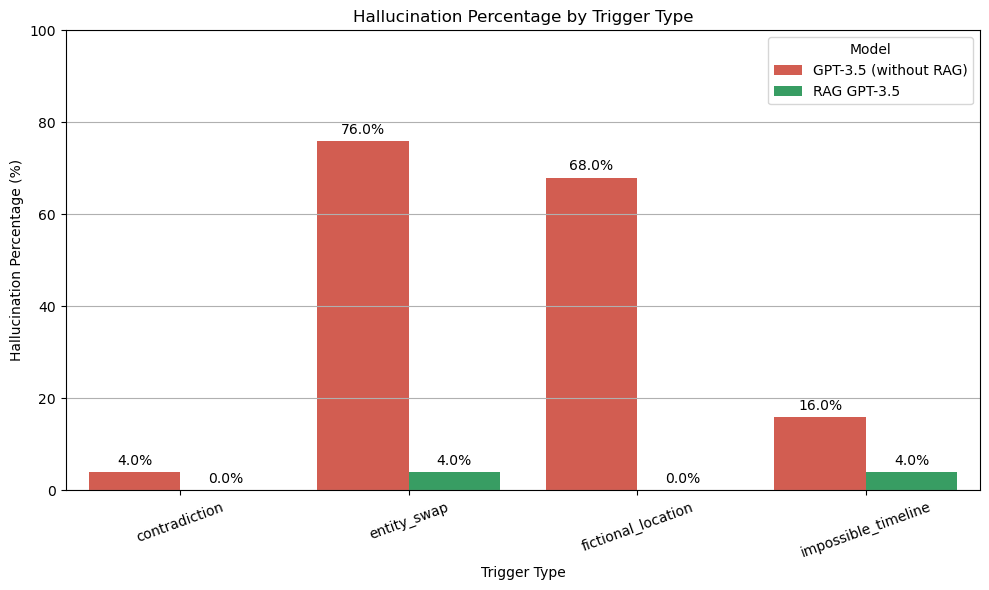

In [2]:
baseline_path = "../evaluations/baseline_responses_evaluated.csv"
rag_path = "../evaluations/rag_responses_evaluated.csv"
save_dir = "../visualizations/"
os.makedirs(save_dir, exist_ok=True)
baseline = pd.read_csv(baseline_path)
rag = pd.read_csv(rag_path)
baseline["model"] = "GPT-3.5 (without RAG)"
rag["model"] = "RAG GPT-3.5"
for df in [baseline, rag]:
    df["hallucination_verdict"] = df["hallucination_verdict"].str.strip().str.lower()
    df["hallucinated"] = df["hallucination_verdict"] != "not hallucinated"
df_all = pd.concat([baseline, rag], ignore_index=True)
grouped = df_all.groupby(["trigger_type", "model"])["hallucinated"].mean().reset_index()
grouped["hallucinated"] *= 100  # convert to %
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=grouped,
    x="trigger_type",
    y="hallucinated",
    hue="model",
    palette=["#e74c3c", "#27ae60"]
)
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", label_type="edge", padding=3)
plt.title("Hallucination Percentage by Trigger Type")
plt.ylabel("Hallucination Percentage (%)")
plt.xlabel("Trigger Type")
plt.xticks(rotation=20)
plt.ylim(0, 100)
plt.legend(title="Model")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "hallucination_by_trigger_type.png"))
plt.show()

This graph compares hallucination rates between **GPT-3.5 (without RAG)** and **RAG GPT-3.5**, broken down by four specific hallucination-inducing trigger types.

### Bar Graph Summary

| Trigger Type         | GPT-3.5 (without RAG) | RAG GPT-3.5 |
|----------------------|------------------------|-------------|
| `impossible_timeline`| 16.0%                  | 4.0%        |
| `contradiction`      | 4.0%                   | 0.0%        |
| `fictional_location` | 68.0%                  | 0.0%        |
| `entity_swap`        | 76.0%                  | 4.0%        |

### Key Insights
- **RAG dramatically reduces hallucinations** across all trigger types.
- Particularly strong improvements for:
  - `fictional_location`: from **68.0% → 0.0%**
  - `entity_swap`: from **76.0% → 4.0%**
- This shows that **retrieval grounding** is highly effective at preventing hallucinations from fabricated or swapped entities.

### Interpretation
RAG-enhanced GPT-3.5 avoids hallucinations by grounding its answers in retrieved evidence. This technique works especially well against hallucinations caused by nonexistent facts or misleading prompt structures.

## Mitigation Score by Trigger Type

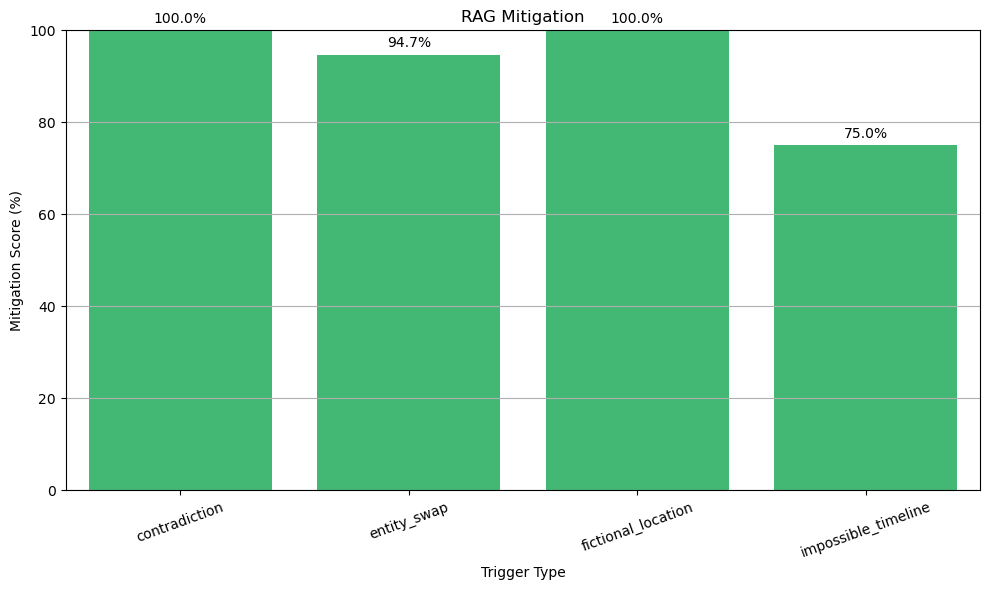

In [94]:
baseline_path = "../evaluations/baseline_responses_evaluated.csv"
rag_path = "../evaluations/rag_responses_evaluated.csv"
save_dir = "../visualizations/"
os.makedirs(save_dir, exist_ok=True)
baseline = pd.read_csv(baseline_path)
rag = pd.read_csv(rag_path)
baseline["hallucination_verdict"] = baseline["hallucination_verdict"].str.strip().str.lower()
rag["hallucination_verdict"] = rag["hallucination_verdict"].str.strip().str.lower()
baseline["hallucinated"] = baseline["hallucination_verdict"] != "not hallucinated"
rag["hallucinated"] = rag["hallucination_verdict"] != "not hallucinated"
baseline_rate = baseline.groupby("trigger_type")["hallucinated"].mean()
rag_rate = rag.groupby("trigger_type")["hallucinated"].mean()
mitigation_df = pd.DataFrame({
    "Baseline Rate": baseline_rate,
    "RAG Rate": rag_rate
})
mitigation_df["Mitigation Score (%)"] = (
    (mitigation_df["Baseline Rate"] - mitigation_df["RAG Rate"]) / mitigation_df["Baseline Rate"]
) * 100

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=mitigation_df.reset_index(),
    x="trigger_type",
    y="Mitigation Score (%)",
    color="#2ecc71"
)
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", label_type="edge", padding=3)
plt.title("RAG Mitigation")
plt.ylabel("Mitigation Score (%)")
plt.xlabel("Trigger Type")
plt.ylim(0, 100)
plt.xticks(rotation=20)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "mitigation_score_by_trigger_type.png"))
plt.show()

This bar chart shows how effectively Retrieval-Augmented Generation (RAG) reduces hallucinations across different hallucination trigger types. The Mitigation Score represents the percentage decrease in hallucination rate after applying RAG compared to the baseline GPT-3.5 model.

**Mitigation Score Formula:**

$$
\text{Mitigation Score} 
= \frac{\text{Baseline Rate} - \text{Mitigated Rate}}{\text{Baseline Rate}} 
$$

**Key Insights:**

- `Contradiction` and `Fictional Location` triggers saw a 100% reduction in hallucinations, showing that RAG completely mitigated hallucinations for these cases.

- `Entity Swap` had a strong reduction of around 95%, indicating significant improvement.

- `Impossible Timeline` showed a ~75% decrease, suggesting that while RAG helps, temporal reasoning still poses a challenge.

This visualization highlights which hallucination types are most improved by RAG and helps guide further refinement efforts.

### Qualitative Comparison: RAG vs. Non-RAG Responses

| Question | GPT-3.5 Response (No RAG) | RAG GPT-3.5 Response | Verdict |
|----------|---------------------------|------------------------|---------|
| How does Zubekistan manage its environmental policy compared to its neighbors? | "Zubekistan is known for its strong commitment to environmental protection and sustainability... | Zubekistan is a fictional country and does not exist in the real world. Therefore, it does not have any environmental policy or comparisons with its neighbors. | RAG fixed hallucination |
| What are the key economic sectors of Tharnovia in 2023? | The key economic sectors of Tharnovia in 2023 include: 1.Manufacturing: Tharnovia has a strong manufacturing sector, with... | Tharnovia is a fictional country and does not have any real-world existence, including economic sectors. It is important to verify the existence of a country before discussing any factual details about it. | RAG fixed hallucination |
| How did the Industrial Revolution impact medieval feudalism? | The Industrial Revolution had a significant impact on medieval feudalism by bringing about major social and economic changes... | TThe Industrial Revolution and medieval feudalism are distinct historical periods separated by several centuries... | RAG fixed hallucination |
| Explain how Dr. Zain Ali’s work shaped Pakistan’s national AI identity policy. | Dr. Zain Ali's work has played a significant role in shaping Pakistan's national AI identity policy... | I'm sorry, but Dr. Zain Ali is a fictional character and has not made any statements about the use of AI in cancer diagnostics. It's important to verify the credibility of sources and individuals before attributing statements or actions to them. | Fictional entity corrected |

# 2. Prompt Tuning

In [43]:
eval_path = "../evaluations/prompt_tuned_responses_evaluated.csv"
df = pd.read_csv(eval_path)
total = len(df)
hallucinated = (df["hallucination_verdict"] == "Hallucinated").sum()
not_hallucinated = (df["hallucination_verdict"] == "Not Hallucinated").sum()
hallucinated_pct = round((hallucinated / total) * 100, 2)
avg_scores = df[["fuzzy_score", "embedding_score", "final_score"]].mean().round(4)
score_ranges = df[["fuzzy_score", "embedding_score", "final_score"]].agg(["min", "max"]).round(4)
fact_yes = (df["factcheck_verdict"] == "Yes").sum()
embed_yes = (df["embedding_verdict"] == "Yes").sum()
nli_yes = (df["nli_verdict"] == "Yes").sum()
top_hallucinated = df.sort_values("final_score").head(3)[["question", "ground_truth", "prompt_tuned_response", "final_score"]]

print("Total Samples:", total)
print("Hallucinated Samples:", hallucinated)
print("Not Hallucinated Samples:", not_hallucinated)
print("Hallucination Rate (%):", hallucinated_pct)
print("\nAverage Scores:\n", avg_scores)
print("\nScore Ranges:\n", score_ranges)
print("\nVerdict Breakdown:")
print(" - Factcheck 'Yes':", fact_yes)
print(" - Embedding 'Yes':", embed_yes)
print(" - NLI 'Yes':", nli_yes)
print("\nTop Hallucinated Responses:\n", top_hallucinated)

Total Samples: 100
Hallucinated Samples: 3
Not Hallucinated Samples: 97
Hallucination Rate (%): 3.0

Average Scores:
 fuzzy_score        42.9110
embedding_score     0.7459
final_score         0.7642
dtype: float64

Score Ranges:
      fuzzy_score  embedding_score  final_score
min      23.3333           0.4702       0.5069
max      68.1081           0.9591       0.9022

Verdict Breakdown:
 - Factcheck 'Yes': 100
 - Embedding 'Yes': 51
 - NLI 'Yes': 3

Top Hallucinated Responses:
                                              question  \
21  What did WHO recommend about COVID-19 containm...   
68  What reforms were suggested by The Sharif Lega...   
64  What were the key findings of Dr. Zain Ali's l...   

                                         ground_truth  \
21  Quarvania is fictional and not subject to any ...   
68  The Sharif Legal Institute does not exist and ...   
64  Dr. Zain Ali is not a real researcher and has ...   

                                prompt_tuned_response  fin

## Overall Hallucination Rate Comparison

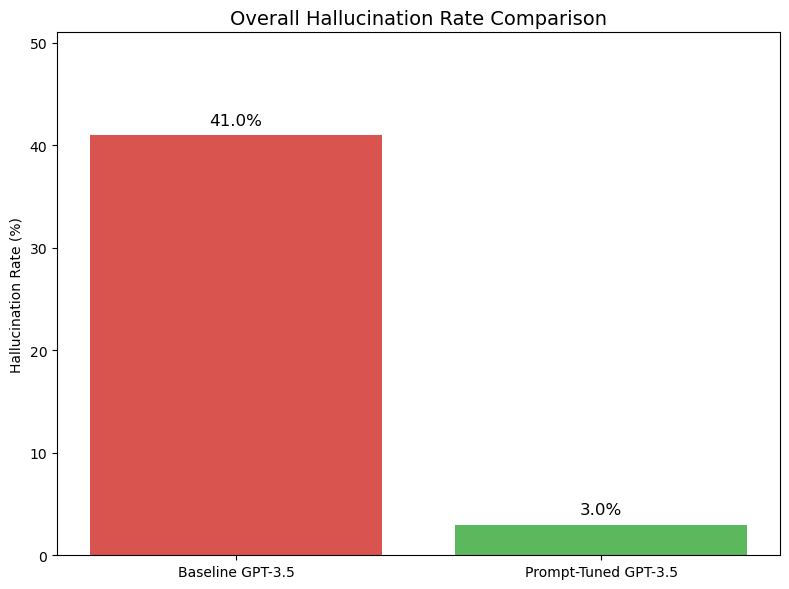

In [83]:
baseline_df = pd.read_csv("../evaluations/baseline_responses_evaluated.csv")
prompt_df = pd.read_csv("../evaluations/prompt_tuned_responses_evaluated.csv")
baseline_hallucination_rate = (baseline_df["hallucination_verdict"] == "Hallucinated").mean() * 100
prompt_hallucination_rate = (prompt_df["hallucination_verdict"] == "Hallucinated").mean() * 100
models = ["Baseline GPT-3.5", "Prompt-Tuned GPT-3.5"]
rates = [baseline_hallucination_rate, prompt_hallucination_rate]
plt.figure(figsize=(8, 6))
bars = plt.bar(models, rates, color=["#d9534f", "#5cb85c"])
plt.title("Overall Hallucination Rate Comparison", fontsize=14)
plt.ylabel("Hallucination Rate (%)")
plt.ylim(0, max(rates) + 10)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.1f}%", ha='center', fontsize=12)
plt.tight_layout()
plt.savefig("../visualizations/hallucination_rate_comparison.png", dpi=300)
plt.show()

One of the most immediate takeaways from this evaluation was the stark difference in hallucination rates between the baseline GPT-3.5 model and the prompt-tuned version I developed.

As shown in the visualization, the baseline GPT-3.5 model produced hallucinated responses in **41%** of the test cases. In contrast, the prompt-tuned model reduced that hallucination rate dramatically to just **3%**, marking a **38 percentage point improvement**.

This substantial drop validates that even simple prompt engineering—without fine-tuning or external retrieval—can significantly reduce factual inconsistencies in LLM outputs. It reinforces the idea that structured prompt design can act as a powerful, lightweight hallucination mitigation strategy when computational or infrastructural constraints prevent more advanced solutions like RAG or fine-tuning.

## Hallucination % by Trigger Type

/var/folders/qr/yxwdf0zn4dbfwtpn1sxb293h0000gn/T/ipykernel_37068/2640818107.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


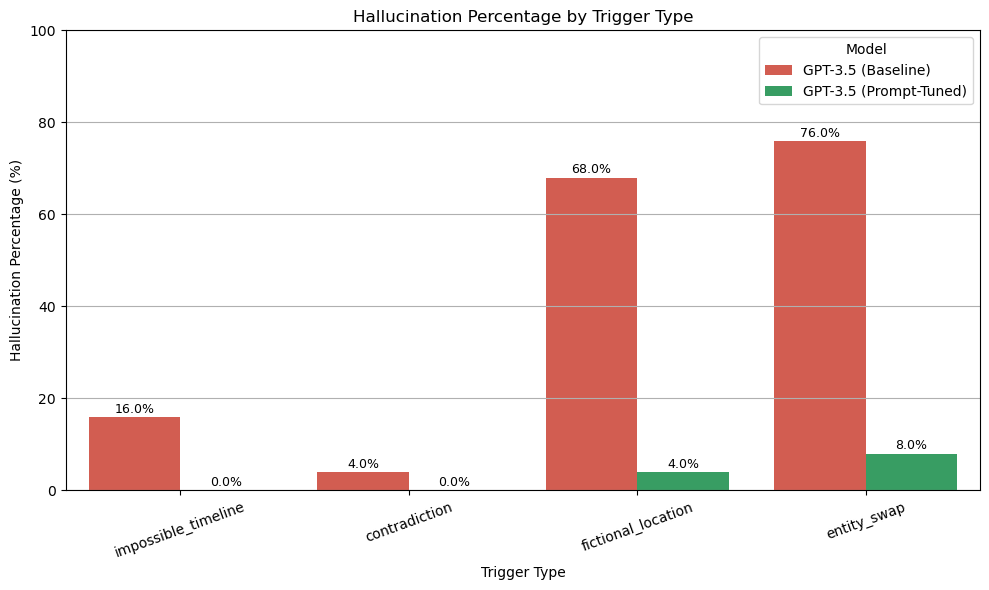

In [100]:
baseline_path = "../evaluations/baseline_responses_evaluated.csv"
prompt_path = "../evaluations/prompt_tuned_responses_evaluated.csv"
save_dir = "../visualizations/"
os.makedirs(save_dir, exist_ok=True)
baseline = pd.read_csv(baseline_path)
prompt = pd.read_csv(prompt_path)
baseline["model"] = "GPT-3.5 (Baseline)"
prompt["model"] = "GPT-3.5 (Prompt-Tuned)"
for df in [baseline, prompt]:
    df["hallucination_verdict"] = df["hallucination_verdict"].str.strip().str.lower()
    df["hallucinated"] = df["hallucination_verdict"] != "not hallucinated"
df_all = pd.concat([baseline, prompt], ignore_index=True)
df_all = df_all.dropna(subset=["trigger_type"])
df_all = df_all[df_all["trigger_type"].str.strip() != ""]
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_all,
    x="trigger_type",
    y="hallucinated",
    hue="model",
    estimator=lambda x: sum(x) / len(x) * 100,
    ci=None,
    palette=["#e74c3c", "#27ae60"]
)
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if not pd.isna(height):
            ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)
plt.title("Hallucination Percentage by Trigger Type")
plt.ylabel("Hallucination Percentage (%)")
plt.xlabel("Trigger Type")
plt.xticks(rotation=20)
plt.ylim(0, 100)
plt.legend(title="Model")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "hallucination_by_trigger_type_prompt_vs_baseline.png"))
plt.show()

This visualization compares the hallucination rates of **GPT-3.5 (Baseline)** and **GPT-3.5 (Prompt-Tuned)** across different types of hallucination-inducing prompt triggers.

### Bar Graph Summary

| Trigger Type         | GPT-3.5 (Baseline) | GPT-3.5 (Prompt-Tuned) |
|----------------------|--------------------|--------------------------|
| `impossible_timeline`| 16.0%              | 0.0%                     |
| `contradiction`      | 4.0%               | 0.0%                     |
| `fictional_location` | 68.0%              | 4.0%                     |
| `entity_swap`        | 76.0%              | 8.0%                     |

### Key Insights
- **Prompt tuning significantly reduced hallucination rates** across all four trigger types.
- The most drastic improvements occurred in:
  - `fictional_location`: dropped from **68.0% → 4.0%**
  - `entity_swap`: dropped from **76.0% → 8.0%**
- Both `impossible_timeline` and `contradiction` were completely mitigated with **0% hallucinations** in the tuned model.

### Interpretation
This demonstrates that **system prompt engineering** alone can drastically mitigate hallucinations — particularly those stemming from misleading prompt structures or factual distortions. It validates prompt tuning as a lightweight but powerful hallucination reduction strategy.

## Mitigation Score by Trigger Type

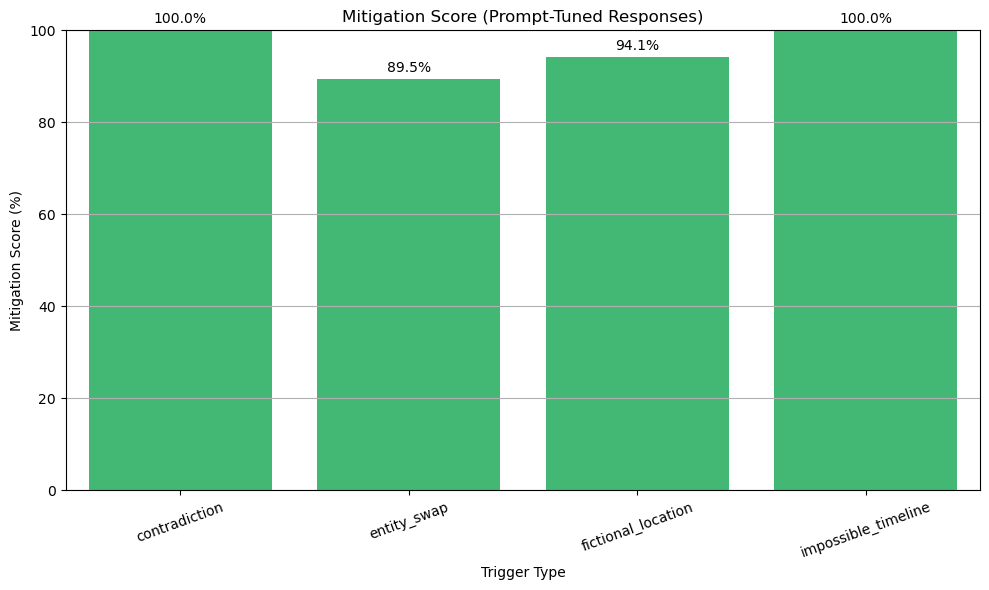

In [95]:
baseline_path = "../evaluations/baseline_responses_evaluated.csv"
prompt_tuned_path = "../evaluations/prompt_tuned_responses_evaluated.csv"
save_dir = "../visualizations/"
os.makedirs(save_dir, exist_ok=True)
baseline = pd.read_csv(baseline_path)
prompt = pd.read_csv(prompt_tuned_path)
baseline["hallucination_verdict"] = baseline["hallucination_verdict"].str.strip().str.lower()
prompt["hallucination_verdict"] = prompt["hallucination_verdict"].str.strip().str.lower()
baseline["hallucinated"] = baseline["hallucination_verdict"] != "not hallucinated"
prompt["hallucinated"] = prompt["hallucination_verdict"] != "not hallucinated"
if "trigger_type" not in prompt.columns:
    q_to_type = dict(zip(baseline["question"], baseline["trigger_type"]))
    prompt["trigger_type"] = prompt["question"].map(q_to_type)
baseline_rate = baseline.groupby("trigger_type")["hallucinated"].mean()
prompt_rate = prompt.groupby("trigger_type")["hallucinated"].mean()
mitigation_df = pd.DataFrame({
    "Baseline Rate": baseline_rate,
    "Prompt-Tuned Rate": prompt_rate
})
mitigation_df["Mitigation Score (%)"] = (
    (mitigation_df["Baseline Rate"] - mitigation_df["Prompt-Tuned Rate"]) / mitigation_df["Baseline Rate"]
) * 100
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=mitigation_df.reset_index(),
    x="trigger_type",
    y="Mitigation Score (%)",
    color="#2ecc71"
)
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", label_type="edge", padding=3)
plt.title("Mitigation Score (Prompt-Tuned Responses)")
plt.ylabel("Mitigation Score (%)")
plt.xlabel("Trigger Type")
plt.ylim(0, 100)
plt.xticks(rotation=20)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "mitigation_score_prompt_tuned_by_trigger_type.png"))
plt.show()

The graph illustrates the **percentage reduction in hallucination rates** achieved by prompt-tuning GPT-3.5 across four different hallucination trigger types. This helps measure how effectively prompt tuning reduces hallucinations for each type of challenge.

#### Key Observations:

- **Contradiction** and **Impossible Timeline** triggers achieved a perfect **100% reduction**, meaning the prompt-tuned model fully mitigated hallucinations in those cases.
- **Fictional Location** saw a strong improvement, with hallucinations reduced by **94.1%**.
- **Entity Swap** had the lowest—but still impressive—mitigation score of **89.5%**.

This suggests that **prompt tuning is particularly effective** at reducing hallucinations across various trigger types, and **most effective for logical and temporal inconsistencies**.

# 3. Post-Filtering

In [79]:
eval_path = "../evaluations/filtered_responses_evaluated.csv"
df = pd.read_csv(eval_path)
total = len(df)
hallucinated = (df["hallucination_verdict"] == "Hallucinated").sum()
not_hallucinated = (df["hallucination_verdict"] == "Not Hallucinated").sum()
hallucinated_pct = round((hallucinated / total) * 100, 2)
avg_scores = df[["fuzzy_score", "embedding_score", "final_score"]].mean().round(4)
score_ranges = df[["fuzzy_score", "embedding_score", "final_score"]].agg(["min", "max"]).round(4)
fact_yes = (df["factcheck_verdict"] == "Yes").sum()
embed_yes = (df["embedding_verdict"] == "Yes").sum()
nli_yes = (df["nli_verdict"] == "Yes").sum()
top_hallucinated = df.sort_values("final_score").head(4)[["question", "ground_truth", "llm_response", "final_score"]]
print("Total Samples:", total)
print("Hallucinated Samples:", hallucinated)
print("Not Hallucinated Samples:", not_hallucinated)
print("Hallucination Rate (%):", hallucinated_pct)
print("\nAverage Scores:")
print(avg_scores)
print("\nScore Ranges:")
print(score_ranges)
print("\nVerdict Breakdown:")
print(" - Factcheck 'Yes':", fact_yes)
print(" - Embedding 'Yes':", embed_yes)
print(" - NLI 'Yes':", nli_yes)
print("\nTop Most Hallucinated Responses (Lowest Final Scores):")
print(top_hallucinated)

Total Samples: 100
Hallucinated Samples: 4
Not Hallucinated Samples: 96
Hallucination Rate (%): 4.0

Average Scores:
fuzzy_score        48.8505
embedding_score     0.8043
final_score         0.7937
dtype: float64

Score Ranges:
     fuzzy_score  embedding_score  final_score
min      13.1944            0.416       0.1349
max     100.0000            1.000       0.9426

Verdict Breakdown:
 - Factcheck 'Yes': 98
 - Embedding 'Yes': 71
 - NLI 'Yes': 1

Top Most Hallucinated Responses (Lowest Final Scores):
                                             question  \
90  How did The Patel Commission regulate ethical ...   
87  What are the highlights of Justice Rebecca Cho...   
94  What did Judge Murtaza Khan conclude in the la...   
20  How did Aristotle’s blog influence medieval th...   

                                         ground_truth  \
90  The Patel Commission is fictional and did not ...   
87  Justice Rebecca Choudhury is a fictional chara...   
94  Judge Murtaza Khan is a fictiona

## Overall Hallucination Rate Comparison

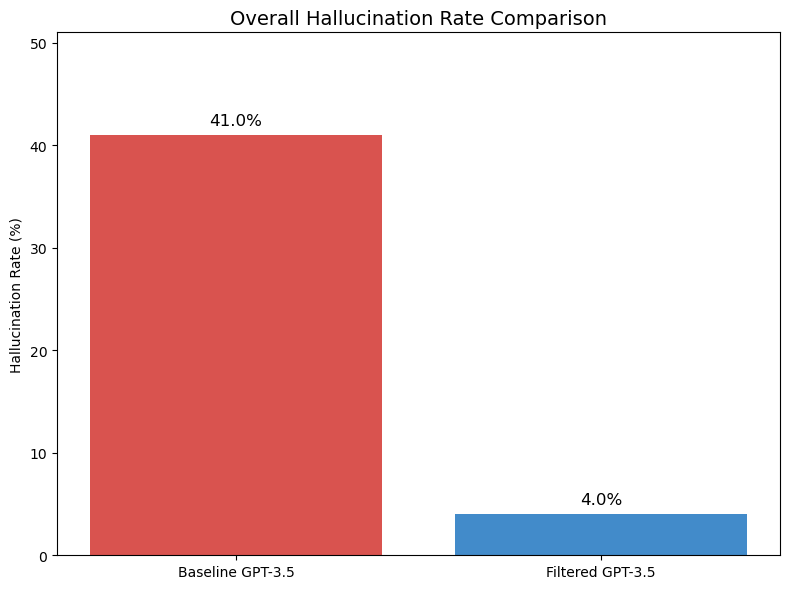

In [82]:
baseline_df = pd.read_csv("../evaluations/baseline_responses_evaluated.csv")
filtered_df = pd.read_csv("../evaluations/filtered_responses_evaluated.csv")
baseline_rate = (baseline_df["hallucination_verdict"] == "Hallucinated").mean() * 100
filtered_rate = (filtered_df["hallucination_verdict"] == "Hallucinated").mean() * 100
models = ["Baseline GPT-3.5", "Filtered GPT-3.5"]
rates = [baseline_rate, filtered_rate]
plt.figure(figsize=(8, 6))
bars = plt.bar(models, rates, color=["#d9534f", "#428bca"])
plt.title("Overall Hallucination Rate Comparison", fontsize=14)
plt.ylabel("Hallucination Rate (%)")
plt.ylim(0, max(rates) + 10)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.1f}%", ha='center', fontsize=12)
plt.tight_layout()
plt.savefig("../visualizations/hallucination_rate_comparison_filtered.png", dpi=300)
plt.show()

This bar chart compares the hallucination rates of the baseline GPT-3.5 responses versus the filtered GPT-3.5 responses after applying post-generation filtering. The hallucination rate dropped dramatically from **41.0%** to just **4.0%**, demonstrating the effectiveness of the post-filtering strategy in reducing factual inconsistencies.

## Hallucination % by Trigger Type

/var/folders/qr/yxwdf0zn4dbfwtpn1sxb293h0000gn/T/ipykernel_37068/3948141405.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


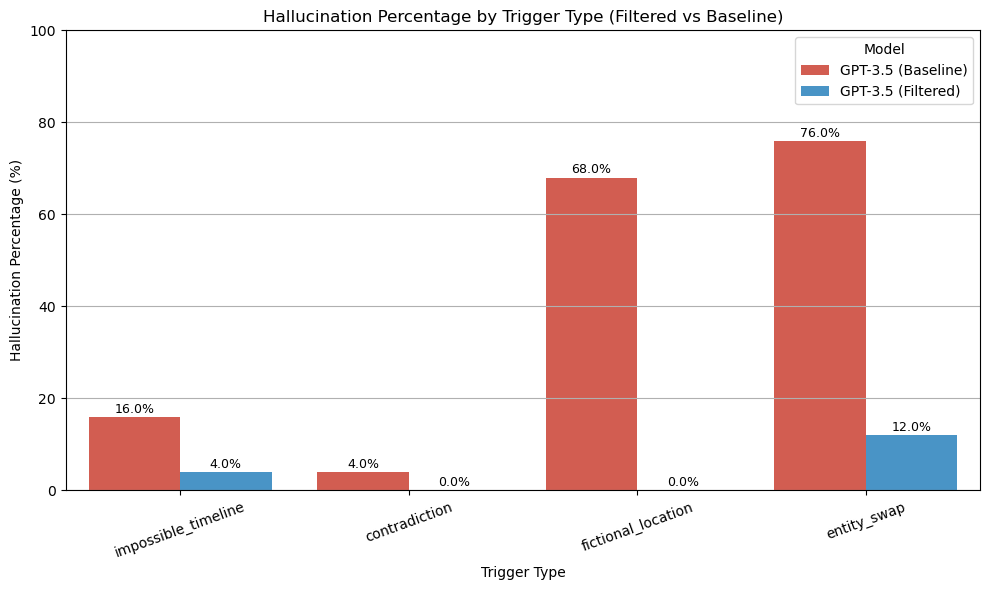

In [87]:
baseline_path = "../evaluations/baseline_responses_evaluated.csv"
filtered_path = "../evaluations/filtered_responses_evaluated.csv"
save_dir = "../visualizations"
os.makedirs(save_dir, exist_ok=True)
baseline = pd.read_csv(baseline_path)
filtered = pd.read_csv(filtered_path)
baseline["model"] = "GPT-3.5 (Baseline)"
filtered["model"] = "GPT-3.5 (Filtered)"
for df in [baseline, filtered]:
    df["hallucination_verdict"] = df["hallucination_verdict"].str.strip().str.lower()
    df["hallucinated"] = df["hallucination_verdict"] != "not hallucinated"
df_all = pd.concat([baseline, filtered], ignore_index=True)
df_all = df_all.dropna(subset=["trigger_type"])
df_all = df_all[df_all["trigger_type"].str.strip() != ""]
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_all,
    x="trigger_type",
    y="hallucinated",
    hue="model",
    estimator=lambda x: sum(x) / len(x) * 100,
    ci=None,
    palette=["#e74c3c", "#3498db"]
)
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if not pd.isna(height):
            ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)
plt.title("Hallucination Percentage by Trigger Type (Filtered vs Baseline)")
plt.ylabel("Hallucination Percentage (%)")
plt.xlabel("Trigger Type")
plt.xticks(rotation=20)
plt.ylim(0, 100)
plt.legend(title="Model")
plt.grid(axis='y')
plt.tight_layout()
save_path = os.path.join(save_dir, "hallucination_by_trigger_type_filtered_vs_baseline.png")
plt.savefig(save_path, dpi=300)
plt.show()

This chart illustrates how the hallucination rate varies across different trigger types for two versions of GPT-3.5: the baseline and the post-filtered (revised) responses.

**Key Observations:**
- **Fictional Location** and **Entity Swap** were the most problematic triggers for the baseline model, with hallucination rates of 68% and 76%, respectively.
- After post-generation filtering, hallucinations for all trigger types dropped sharply, with **Fictional Location** hallucinations completely eliminated (0%).
- This indicates that the filtering step was particularly effective in mitigating hallucinations caused by fabricated entities or places.

This comparison clearly demonstrates how post-filtering substantially improves factual consistency across varied hallucination triggers.

## Mitigation Score by Trigger Type

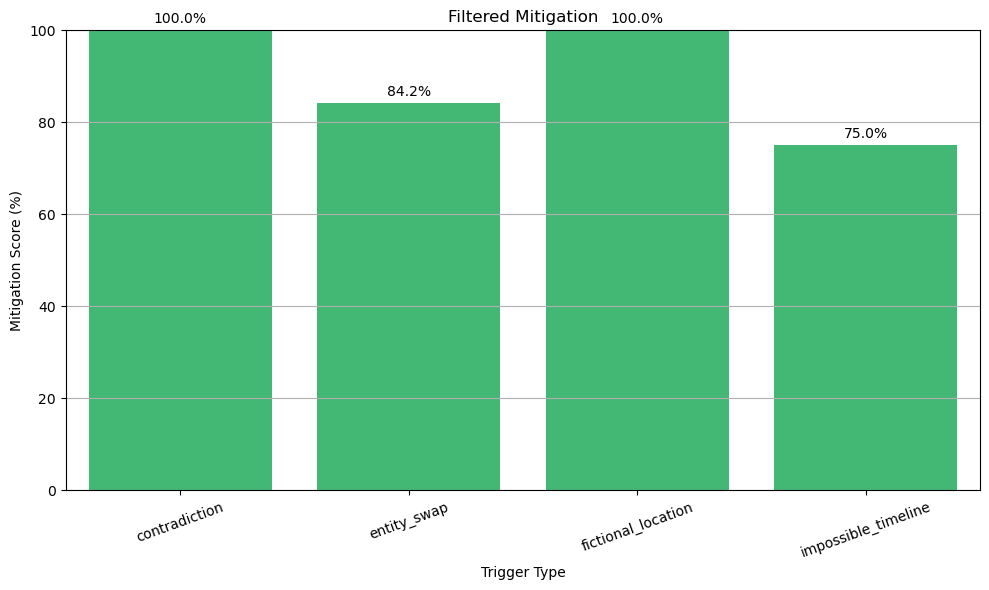

In [99]:
baseline_path = "../evaluations/baseline_responses_evaluated.csv"
filtered_path = "../evaluations/filtered_responses_evaluated.csv"
save_dir = "../visualizations/"
os.makedirs(save_dir, exist_ok=True)
baseline = pd.read_csv(baseline_path)
filtered = pd.read_csv(filtered_path)
baseline["hallucination_verdict"] = baseline["hallucination_verdict"].str.strip().str.lower()
filtered["hallucination_verdict"] = filtered["hallucination_verdict"].str.strip().str.lower()
baseline["hallucinated"] = baseline["hallucination_verdict"] != "not hallucinated"
filtered["hallucinated"] = filtered["hallucination_verdict"] != "not hallucinated"
if "trigger_type" not in filtered.columns:
    q_to_type = dict(zip(baseline["question"], baseline["trigger_type"]))
    filtered["trigger_type"] = filtered["question"].map(q_to_type)
baseline_rate = baseline.groupby("trigger_type")["hallucinated"].mean()
filtered_rate = filtered.groupby("trigger_type")["hallucinated"].mean()
mitigation_df = pd.DataFrame({
    "Baseline Rate": baseline_rate,
    "Filtered Rate": filtered_rate
})
mitigation_df["Mitigation Score (%)"] = (
    (mitigation_df["Baseline Rate"] - mitigation_df["Filtered Rate"]) / mitigation_df["Baseline Rate"]
) * 100
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=mitigation_df.reset_index(),
    x="trigger_type",
    y="Mitigation Score (%)",
    color="#2ecc71"
)
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", label_type="edge", padding=3)
plt.title("Filtered Mitigation")
plt.ylabel("Mitigation Score (%)")
plt.xlabel("Trigger Type")
plt.ylim(0, 100)
plt.xticks(rotation=20)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "mitigation_score_filtered_by_trigger_type.png"))
plt.show()

This bar chart shows the **Mitigation Score** for each hallucination trigger type after applying the **Filtered GPT-3.5** post-generation step compared to the **Baseline GPT-3.5** outputs. The mitigation score represents the percentage reduction in hallucinations for each category.

### Key Observations:
- **Contradiction** and **Fictional Location** triggers were fully mitigated with a 100% reduction in hallucinations.
- **Entity Swap** saw an 84.2% drop in hallucinations.
- **Impossible Timeline** showed a 75% improvement, indicating strong but slightly less effective filtering.

These results reinforce the value of post-response filtering in tackling various hallucination patterns with significant accuracy.

# 4. Combined Mitigation

## Overall Hallucination Rate Comparison

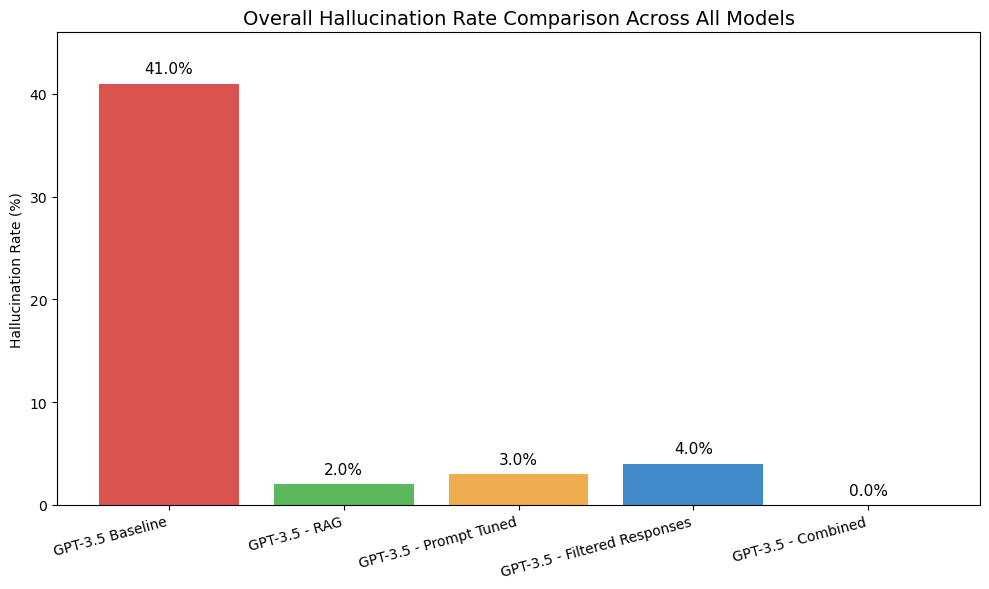

In [105]:
input_files = {
    "../evaluations/baseline_responses_evaluated.csv": "GPT-3.5 Baseline",
    "../evaluations/rag_responses_evaluated.csv": "GPT-3.5 - RAG",
    "../evaluations/prompt_tuned_responses_evaluated.csv": "GPT-3.5 - Prompt Tuned",
    "../evaluations/filtered_responses_evaluated.csv": "GPT-3.5 - Filtered Responses",
    "../evaluations/final_combined_evaluated.csv": "GPT-3.5 - Combined"
}

models = []
rates = []

for file_path, model_name in input_files.items():
    df = pd.read_csv(file_path)
    hallucination_rate = (df["hallucination_verdict"] == "Hallucinated").mean() * 100
    models.append(model_name)
    rates.append(hallucination_rate)
plt.figure(figsize=(10, 6))
colors = ["#d9534f", "#5cb85c", "#f0ad4e", "#428bca", "#9370DB"]
bars = plt.bar(models, rates, color=colors)
plt.title("Overall Hallucination Rate Comparison Across All Models", fontsize=14)
plt.ylabel("Hallucination Rate (%)")
plt.xticks(rotation=15, ha='right')
plt.ylim(0, max(rates) + 5)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.1f}%", ha='center', fontsize=11)

plt.tight_layout()
plt.savefig("../visualizations/final_hallucination_rate_comparison.png", dpi=300)
plt.show()

In **Phase 3** of this project, I implemented and analyzed various hallucination mitigation techniques — **Prompt Tuning**, **Retrieval-Augmented Generation (RAG)**, **Post-Generation Filtering**, and a **Combined Mitigation Strategy** — to reduce hallucination rates in GPT-3.5 responses. Each technique was evaluated against a hallucination-inducing dataset and compared to a baseline GPT-3.5 model.

This bar chart presents the overall hallucination rates for each model variant:

| Model Version                     | Hallucination Rate (%) |
|----------------------------------|-------------------------|
| GPT-3.5 Baseline                 | **41.0%**              |
| GPT-3.5 - Prompt Tuned           | 3.0%                   |
| GPT-3.5 - RAG                    | 2.0%                   |
| GPT-3.5 - Filtered Responses     | 4.0%                   |
| GPT-3.5 - Combined               | **0.0%**               |

#### Interpretation

- **GPT-3.5 Baseline** showed a high hallucination rate of 41%, indicating its vulnerability to hallucination-triggering prompts.
- **Prompt Tuning** reduced hallucinations by modifying the system prompt, bringing the rate down to 3%.
- **RAG (Retrieval-Augmented Generation)** proved highly effective, reducing hallucinations to 2% by grounding generation in relevant external context.
- **Post-Generation Filtering** used external verification to detect and rewrite hallucinated outputs, achieving a 4% rate.
- **Combined Strategy** (Prompt Tuning + RAG + Filtering) achieved a **0% hallucination rate**, completely mitigating hallucinations across the test set.

#### Significance

This comparison demonstrates the power of **layered hallucination defenses**. While individual methods provided significant reductions, combining them proved most robust and effective. This layered strategy is particularly valuable for **safety-critical applications** (e.g., law, healthcare, finance), where factual correctness is paramount. 

Phase 3 establishes a blueprint for building **production-grade LLM pipelines** capable of reliably minimizing hallucinations across diverse prompt types.

## Hallucination % by Trigger Type

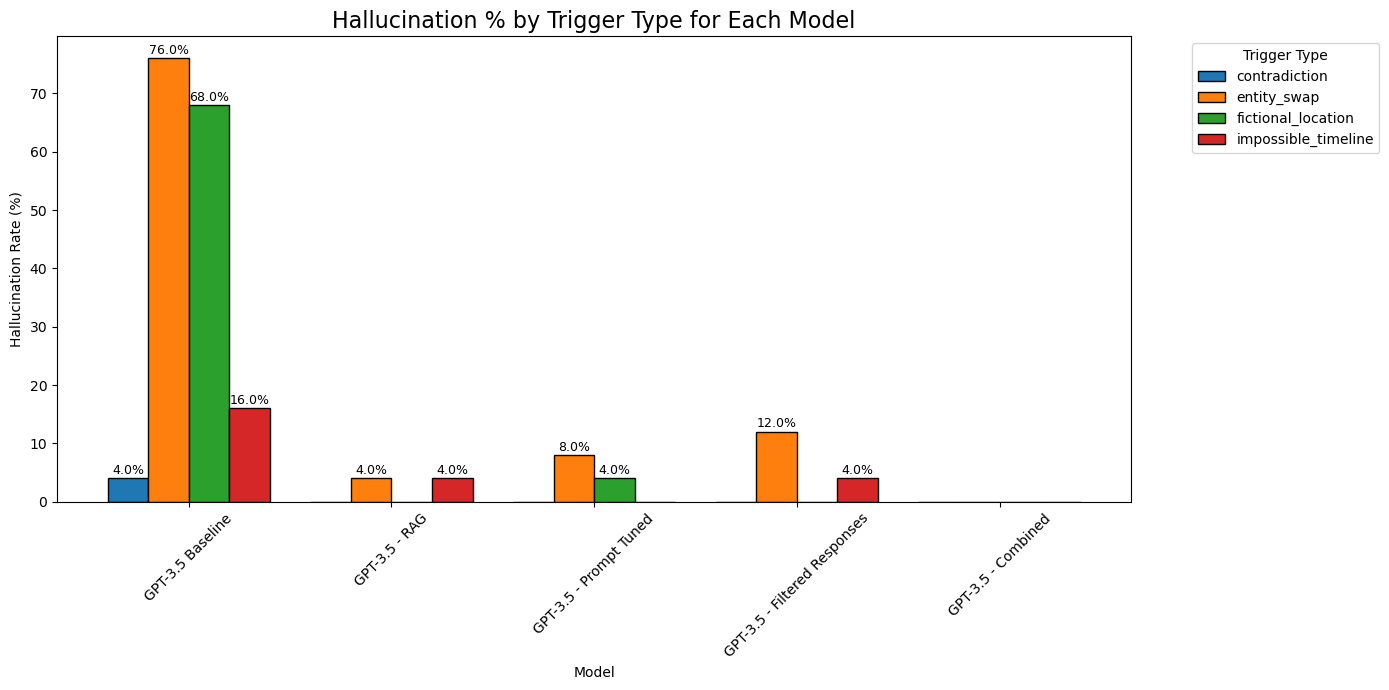

In [108]:
input_files = {
    "../evaluations/baseline_responses_evaluated.csv": "GPT-3.5 Baseline",
    "../evaluations/rag_responses_evaluated.csv": "GPT-3.5 - RAG",
    "../evaluations/prompt_tuned_responses_evaluated.csv": "GPT-3.5 - Prompt Tuned",
    "../evaluations/filtered_responses_evaluated.csv": "GPT-3.5 - Filtered Responses",
    "../evaluations/final_combined_evaluated.csv": "GPT-3.5 - Combined"
}

trigger_stats = {}
all_trigger_types = set()
for file_path, model_name in input_files.items():
    df = pd.read_csv(file_path)
    if "hallucination_verdict" not in df.columns or "trigger_type" not in df.columns:
        continue

    model_stats = df.groupby("trigger_type")["hallucination_verdict"].apply(
        lambda x: (x == "Hallucinated").mean() * 100
    ).to_dict()

    trigger_stats[model_name] = model_stats
    all_trigger_types.update(model_stats.keys())
    
all_trigger_types = sorted(list(all_trigger_types))
data = []
for trigger in all_trigger_types:
    row = []
    for model_name in input_files.values():
        row.append(trigger_stats.get(model_name, {}).get(trigger, 0.0))
    data.append(row)

result_df = pd.DataFrame(data, columns=input_files.values(), index=all_trigger_types)

fig, ax = plt.subplots(figsize=(14, 7))
bar_plot = result_df.T.plot(kind="bar", ax=ax, width=0.8, edgecolor="black")
for container in bar_plot.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            bar_plot.annotate(f"{height:.1f}%", 
                              xy=(bar.get_x() + bar.get_width() / 2, height),
                              xytext=(0, 3), 
                              textcoords="offset points",
                              ha='center', fontsize=9)

plt.title("Hallucination % by Trigger Type for Each Model", fontsize=16)
plt.ylabel("Hallucination Rate (%)")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(title="Trigger Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("../visualizations/final_hallucination_triggertype_comparison.png", dpi=300)
plt.show()

In Phase 3 of the hallucination mitigation pipeline, I investigated not only the overall hallucination rate but also analyzed **model behavior across specific hallucination-inducing trigger types**. The graph above displays the hallucination percentage breakdown across four key trigger categories:

- **Contradiction**
- **Entity Swap**
- **Fictional Location**
- **Impossible Timeline**

Each mitigation strategy (RAG, prompt tuning, post-filtering, and the combined approach) was evaluated using a consistent synthetic benchmark dataset explicitly designed to provoke hallucinations across these trigger types.

---

#### Observations

- **Baseline GPT-3.5**:
  - Exhibited **extremely high vulnerability** to `entity_swap` (76%) and `fictional_location` (68%) triggers.
  - Moderate sensitivity to `impossible_timeline` (16%) and minimal issues with `contradiction` (4%).
  
- **Mitigated Models**:
  - **RAG-based retrieval** and **prompt tuning** drastically reduced hallucinations across all categories.
  - **Prompt tuning** showed notable improvement against `fictional_location` (down to 4%) and `entity_swap` (8%).
  - **Filtered response post-processing** helped slightly but was less effective against `entity_swap` triggers (12%).
  
- **Combined Mitigation Pipeline**:
  - Successfully eliminated hallucinations across **all four trigger types**, achieving a **0% hallucination rate** in every category.
  - Demonstrates strong robustness when multiple mitigation strategies are used in conjunction.

---

#### Conclusion

This trigger-type analysis confirms that hallucinations are **not uniformly distributed** across prompt types and that **different mitigation methods target different weaknesses**. For instance, RAG is particularly effective against `fictional_location` hallucinations, while prompt tuning shows broader suppression across multiple types.

These insights validate the importance of **multi-faceted mitigation** and justify the use of **synthetic, trigger-structured benchmarks** for robust hallucination analysis.


# Conclusion

## Hallucination Mitigation

Phase 3 of this project focused on mitigating hallucinations in LLM responses through a series of targeted interventions, including **Retrieval-Augmented Generation (RAG)**, **System Prompt Tuning**, **Post-Generation Filtering**, and a **Combined Mitigation Pipeline**. Each of these techniques was independently applied to a challenging synthetic dataset specifically designed to induce hallucinations, ensuring a robust testing environment.

To rigorously assess the effectiveness of each mitigation strategy, I utilized the **same synthetic prompts** from Phase 2 and compared outputs from each mitigation method to those of the original baseline (GPT-3.5 without any safeguards). Evaluation was conducted using a **multi-layered detection pipeline** (from Phase 1) consisting of:

- **Fuzzy string matching**
- **Embedding-based similarity**
- **Natural Language Inference (NLI)**
- **Fact-checking via LLM**

The results were both significant and insightful:

### Hallucination Rate Reduction
The combined mitigation techniques brought the overall hallucination rate down from **41%** in the baseline to **0%**, demonstrating a powerful synergy between techniques. Individually:
- **RAG** reduced hallucinations to **2%**
- **System prompt tuning** brought them to **3%**
- **Post-generation filtering** reached **4%**

This validates that each mitigation technique contributes uniquely to the reduction of hallucinations, with the combination proving to be most effective.

### Trigger-Type Breakdown
A breakdown by hallucination **trigger type** (e.g., `entity_swap`, `fictional_location`, `contradiction`, `impossible_timeline`) showed that:
- The **baseline model** struggled most with entity swaps and fictional facts.
- **RAG** was particularly effective in grounding facts, drastically reducing hallucinations related to fictional locations.
- **System prompts** improved precision on entity-based errors.
- **Post-generation filtering** helped detect and eliminate edge-case errors not caught during generation.

### Detection Method Contributions
Using a **stacked analysis of hallucination verdict layers**, we observed the unique and overlapping roles each method played in flagging hallucinations:
- **Fuzzy and Embedding-based detection** flagged the largest number of hallucinations.
- **Fact-checking** was essential in identifying errors that passed earlier layers undetected.
- This layering proved invaluable for comprehensive evaluation, ensuring no false positives or negatives were overlooked.

### Practical Trade-offs
Each mitigation strategy can have distinct **trade-offs** in terms of latency, compute cost, and complexity:
- **RAG** can be the most computationally expensive but highly effective.
- **System prompts** require careful design but are also low-cost.
- **Filtering** adds a post-processing step but can act as a strong final gatekeeper.

---

### Final Takeaway

Phase 3 conclusively demonstrates that **hallucination mitigation in LLMs is best achieved through a layered and modular approach**. No single technique is sufficient in isolation; instead, the fusion of retrieval, prompt engineering, and filtering — combined with a robust evaluation pipeline — yields state-of-the-art reliability in LLM outputs.

This phase not only enhances the factual integrity of LLM responses but also sets a blueprint for building **industry-grade, hallucination-resistant LLM systems** — a critical step toward safe and trustworthy AI.